<a href="https://colab.research.google.com/github/akashglol/StockModel/blob/main/aistockpredictionmdoel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
31/31 [==============================] - 10s 167ms/step - loss: 6.9390e-04 - val_loss: 0.0022
Epoch 2/50
31/31 [==============================] - 4s 131ms/step - loss: 1.1701e-04 - val_loss: 0.0048
Epoch 3/50
31/31 [==============================] - 7s 245ms/step - loss: 9.8986e-05 - val_loss: 0.0048
Epoch 4/50
31/31 [==============================] - 4s 131ms/step - loss: 8.3534e-05 - val_loss: 0.0037
Epoch 5/50
31/31 [==============================] - 4s 143ms/step - loss: 6.9747e-05 - val_loss: 0.0026
Epoch 6/50
31/31 [==============================] - 5s 163ms/step - loss: 7.8147e-05 - val_loss: 0.0041
Epoch 7/50
31/31 [==============================] - 4s 132ms/step - loss: 6.0927e-05 - val_loss: 0.0037
Epoch 8/50
31/31 [==============================] - 4s 144ms/step - loss: 5.6391e-05 - val_loss: 0.0040
Epoch 9/50
31/31 [==============================] - 5s 160ms/step - loss: 7.0829e-05 - val_loss: 0.0032
Epoch 10/50
31/31 [==============================] - 4s 131ms/s

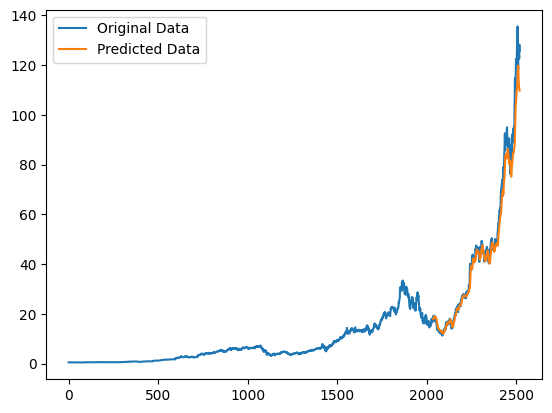

1/1 [==============================] - 0s 27ms/step


ValueError: non-broadcastable output operand with shape (7,1) doesn't match the broadcast shape (7,5)

In [23]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta

# Download stock data
stock_data = yf.download('NVDA', start='2014-07-01', end='2024-07-08')

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data[['Close', 'Open', 'High', 'Low', 'Volume']].values)

# Create dataset
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step, 0])  # Predicting 'Close' price
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=64))
model.add(Dense(units=1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Predict the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:, 0]

# Plot the original and predicted data
original_data = stock_data['Close'].values
predicted_data = np.empty_like(original_data)
predicted_data[:] = np.nan
predicted_data[-len(predictions):] = predictions

plt.plot(original_data, label='Original Data')
plt.plot(predicted_data, label='Predicted Data')
plt.legend()
plt.show()

# Predict the next week's stock prices
X_input = scaled_data[-time_step:].reshape(1, time_step, X.shape[2])
predictions = []

for _ in range(7):
    next_prediction = model.predict(X_input)
    predictions.append(next_prediction[0, 0])
    next_input = np.concatenate((next_prediction, np.zeros((1, 4))), axis=1)
    X_input = np.append(X_input[:, 1:, :], next_input.reshape(1, 1, X.shape[2]), axis=1)

predicted_prices = scaler.inverse_transform(np.concatenate((np.array(predictions).reshape(-1, 1), np.zeros((len(predictions), 4))), axis=1))[:, 0]

# Generate dates for the next week
dates = [datetime.now().date() + timedelta(days=i) for i in range(7)]

# Plotting the predictions
plt.figure(figsize=(14, 7))
plt.plot(dates, predicted_prices, marker='o', linestyle='-', color='orange', label='Predicted Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Predicted Stock Prices for the Next Week')
plt.legend()
plt.grid(True)
plt.show()

# Print the predicted opening and closing prices for each day
print("Predicted Opening and Closing Prices for the Next Week:")
for i, date in enumerate(dates):
    print(f"{date}: Open: {predicted_prices[i]:.2f}, Close: {predicted_prices[i]:.2f}")
